In [4]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES
from configuration.settings import current_density_parameters, physical_parameters, computing_parameters, operating_inputs
from model.AlphaPEM import AlphaPEM
import numpy as np
import pandas as pd

param_grids = {}
for param, bounds in PARAMETER_RANGES.items():
    if isinstance(bounds, tuple):
        grid = np.linspace(bounds[0], bounds[1], num=20) 
    elif isinstance(bounds, list):
        grid = bounds
    param_grids[param] = grid

default_values = {'Tfc': 347.15,
 'Pa_des': 2.5e5,
 'Pc_des': 2.5e5,
 'Sa': 1.2,
 'Sc': 2,
 'Phi_a_des': 0.4,
 'Phi_c_des': 0.6,
 'epsilon_gdl': 0.701,
 'tau': 1.02,
 'epsilon_mc': 0.399,
 'epsilon_c': 0.271,
 'e': 5,
 'Re': 5.7e-7,
 'i0_c_ref': 2.79,
 'kappa_co': 27.2,
 'kappa_c': 1.61,
 'a_slim': 0.056,
 'b_slim': 0.105,
 'a_switch': 0.637}

# Build DataFrame by varying one parameter at a time
rows = []
for param, grid in param_grids.items():
    for value in grid:
        row = default_values.copy()
        row[param] = value
        rows.append(row)

# Final DataFrame
df = pd.DataFrame(rows)

In [32]:
df[PARAMETER_RANGES.keys()]

,Tfc,Pa_des,Pc_des,Sa,Phi_a_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,e,Re,i0_c_ref,kappa_co,kappa_c,a_slim,b_slim,a_switch
0,333.000000,250000.0,250000.0,1.2,0.4,0.701,1.02,0.399,0.271,5,5.700000e-07,2.79,27.2,1.61,0.056,0.105,0.637000
1,334.578947,250000.0,250000.0,1.2,0.4,0.701,1.02,0.399,0.271,5,5.700000e-07,2.79,27.2,1.61,0.056,0.105,0.637000
2,336.157895,250000.0,250000.0,1.2,0.4,0.701,1.02,0.399,0.271,5,5.700000e-07,2.79,27.2,1.61,0.056,0.105,0.637000
3,337.736842,250000.0,250000.0,1.2,0.4,0.701,1.02,0.399,0.271,5,5.700000e-07,2.79,27.2,1.61,0.056,0.105,0.637000
4,339.315789,250000.0,250000.0,1.2,0.4,0.701,1.02,0.399,0.271,5,5.700000e-07,2.79,27.2,1.61,0.056,0.105,0.637000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,347.150000,250000.0,250000.0,1.2,0.4,0.701,1.02,0.399,0.271,5,5.700000e-07,2.79,27.2,1.61,0.056,0.105,0.789474
319,347.150000,250000.0,250000.0,1.2,0.4,0.701,1.02,0.399,0.271,5,5.700000e-07,2.79,27.2,1.61,0.056,0.105,0.842105
320,347.150000,250000.0,250000.0,1.2,0.4,0.701,1.02,0.399,0.271,5,5.700000e-07,2.79,27.2,1.61,0.056,0.105,0.894737
321,347.150000,250000.0,250000.0,1.2,0.4,0.701,1.02,0.399,0.271,5,5.700000e-07,2.79,27.2,1.61,0.056,0.105,0.947368


In [33]:
def build_fixed_parameters():
    type_current="polarization"
    type_fuel_cell="EH-31_2.0"
    t_step, i_step, delta_pola, i_EIS, ratio_EIS, f_EIS, t_EIS, current_density = current_density_parameters(type_current)
    # Operating conditions
    *_, i_max_pola = operating_inputs(type_fuel_cell)
    
    # Physical parameters
    Hcl, epsilon_mc, tau, Hmem, Hgdl, epsilon_gdl, epsilon_c, Hgc, Wgc, Lgc, Aact, e, Re, i0_c_ref, kappa_co, \
        kappa_c, a_slim, b_slim, a_switch, C_scl = physical_parameters(type_fuel_cell)
    # Computing parameters
    max_step, n_gdl, t_purge = computing_parameters(type_current, Hgdl, Hcl)

    return {
        "t_step": t_step,
        "i_step": i_step,
        "delta_pola": delta_pola,
        "i_EIS": i_EIS,
        "ratio_EIS": ratio_EIS,
        "f_EIS": f_EIS,
        "t_EIS": t_EIS,
        "current_density": current_density,
        "max_step": max_step,
        "n_gdl": n_gdl,
        "t_purge": t_purge,
        "type_fuel_cell": "manual_setup", 
        "type_current": "polarization",
        "type_auxiliary": "no_auxiliary",
        "type_control": "no_control",
        "type_purge": "no_purge",
        "type_display": "no_display",
        "type_plot": "fixed",
        "C_scl": C_scl,
        "i_max_pola": i_max_pola,
        "Aact": Aact,
        "Hgdl": Hgdl,
        "Hmem": Hmem,
        "Hcl": Hcl,
        "Hgc": Hgc,
        "Wgc": Wgc,
        "Lgc": Lgc,
    }

In [34]:
saved_data_file = False
save_filepath = "../data/raw/PDP_20_default.pkl"
if saved_data_file:
    data = pd.read_pickle(save_filepath)
else:
    df = get_polarisation_curve_samples(sampled_parameters=df.to_dict(orient='records'), fixed_parameters=build_fixed_parameters(), save_path=save_filepath, save_every=10)


✅ Saved 10 samples to ../data/raw/PDP_20_default.pkl
✅ Saved 20 samples to ../data/raw/PDP_20_default.pkl
✅ Saved 30 samples to ../data/raw/PDP_20_default.pkl
✅ Saved 40 samples to ../data/raw/PDP_20_default.pkl
✅ Saved 50 samples to ../data/raw/PDP_20_default.pkl
✅ Saved 60 samples to ../data/raw/PDP_20_default.pkl
✅ Saved 70 samples to ../data/raw/PDP_20_default.pkl
✅ Saved 80 samples to ../data/raw/PDP_20_default.pkl
✅ Saved 90 samples to ../data/raw/PDP_20_default.pkl
✅ Saved 100 samples to ../data/raw/PDP_20_default.pkl
✅ Saved 110 samples to ../data/raw/PDP_20_default.pkl
❌ Sample 119 not valid: {'Tfc': 347.15, 'Pa_des': 250000.0, 'Pc_des': 250000.0, 'Sa': 1.2, 'Sc': 2, 'Phi_a_des': 0.4, 'Phi_c_des': 0.6, 'epsilon_gdl': 0.8, 'tau': 1.02, 'epsilon_mc': 0.399, 'epsilon_c': 0.271, 'e': 5, 'Re': 5.7e-07, 'i0_c_ref': 2.79, 'kappa_co': 27.2, 'kappa_c': 1.61, 'a_slim': 0.056, 'b_slim': 0.105, 'a_switch': 0.637}
   Error: In order to calculate the effects of the GDL compression on its st


Analyzing parameter: Tfc


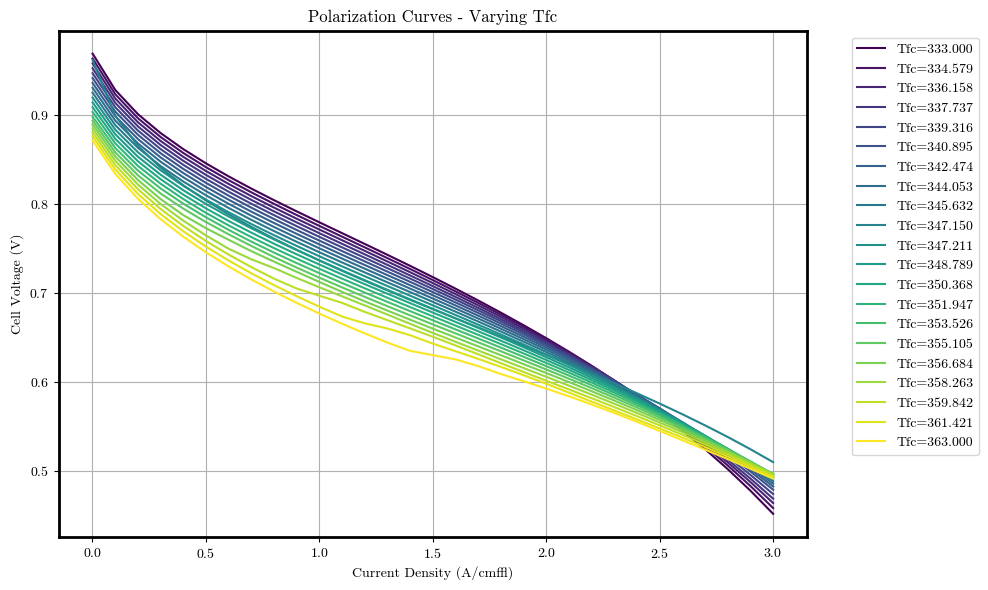


Analyzing parameter: Pa_des


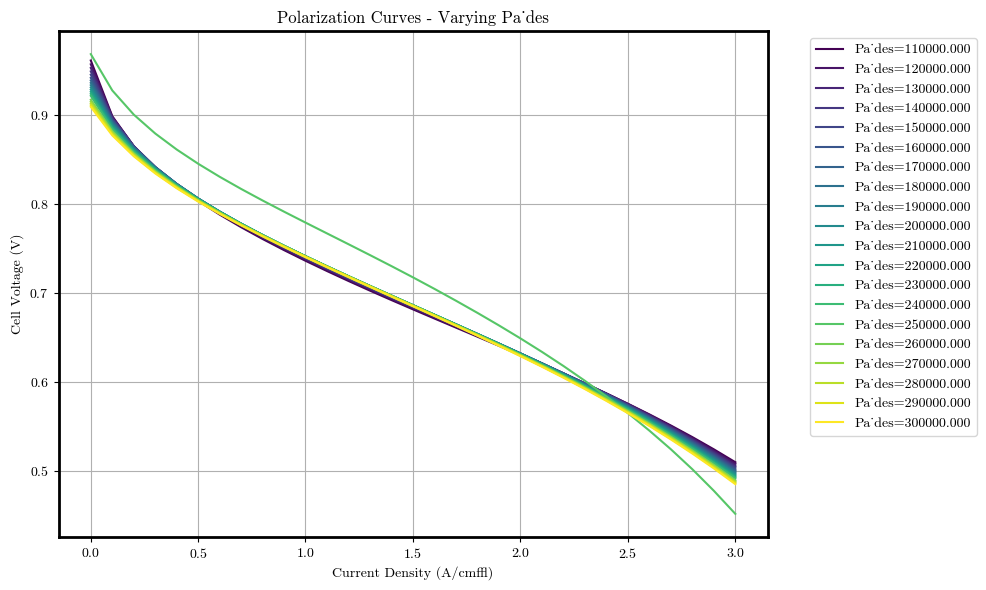


Analyzing parameter: Pc_des


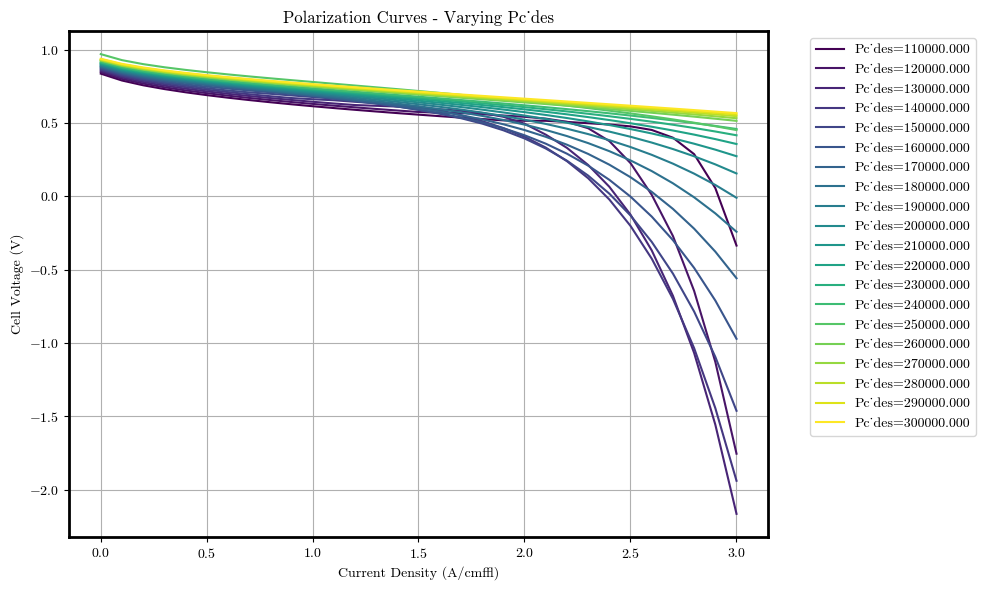


Analyzing parameter: Sa


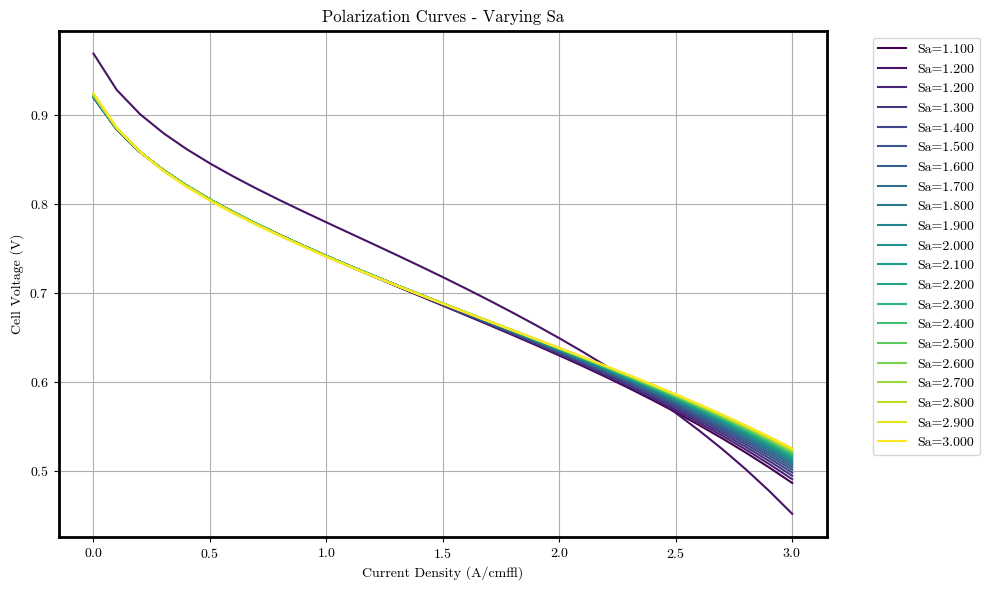


Analyzing parameter: Phi_a_des


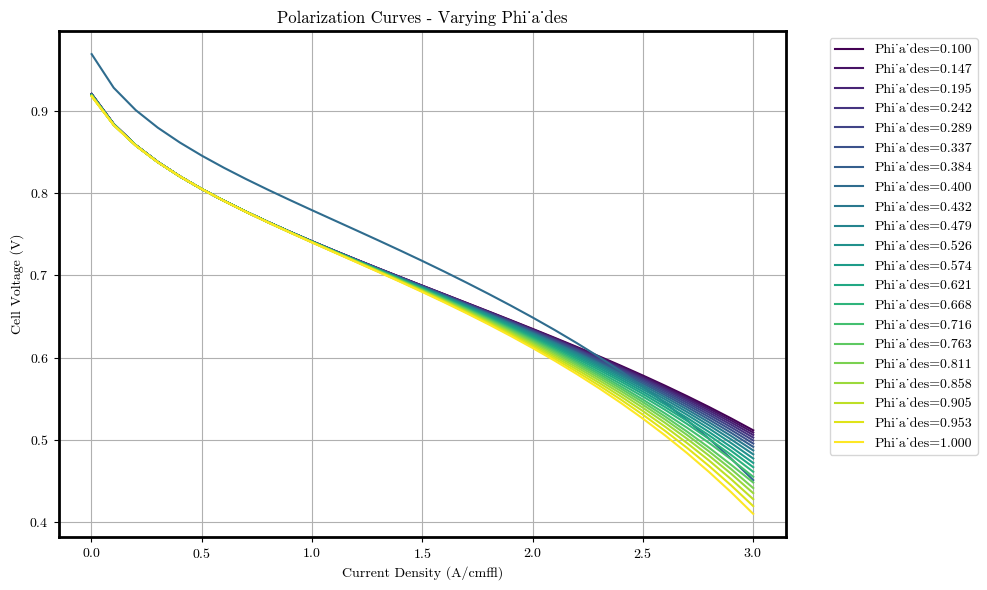


Analyzing parameter: epsilon_gdl


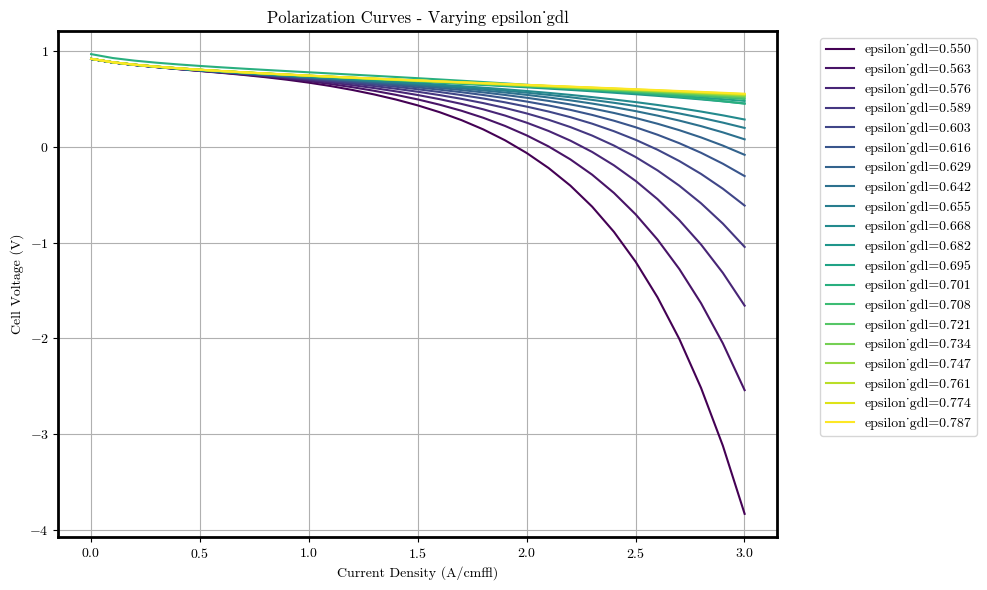


Analyzing parameter: tau


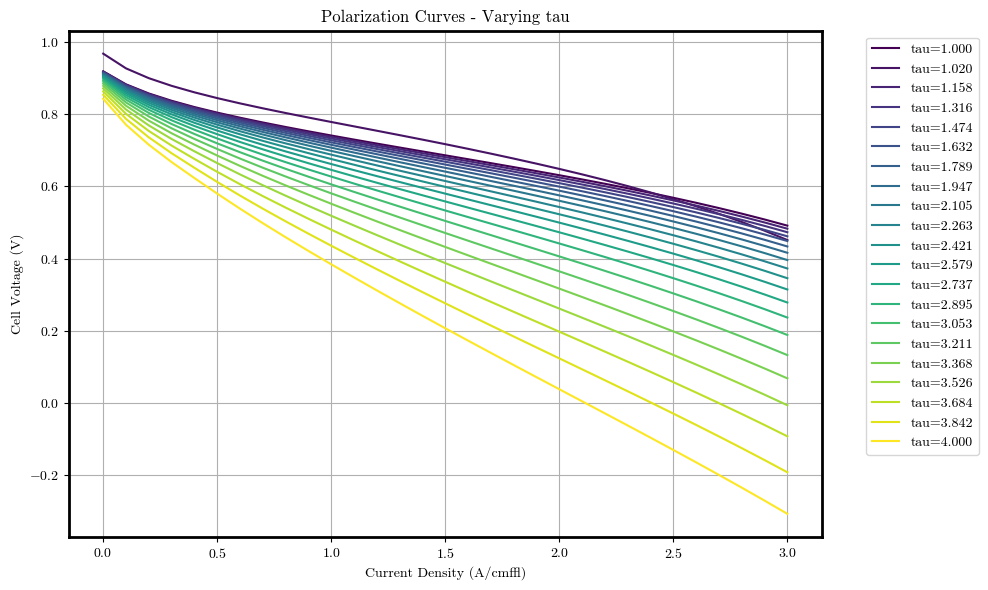

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the parameters we want to analyze
PARAMETER_RANGES = {
    'Tfc': (333, 353),
    'Pa_des': (150000, 250000),
    'Pc_des': (150000, 250000),
    'Sa': (1.2, 2),
    'Phi_a_des': (0.4, 0.8),
    'epsilon_gdl': (0.6, 0.8),
    'tau': (1.02, 1.5)
}

def plot_polarization_curves_for_param(data, param_name):
    """
    Plot polarization curves for different values of a single parameter using a color gradient
    
    Args:
        data (pd.DataFrame): DataFrame containing the simulation results
        param_name (str): Name of the parameter to analyze
    """
    plt.figure(figsize=(10, 6))
    
    # Get unique values for the parameter
    unique_values = sorted(data[param_name].unique())
    
    # Create color gradient
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))
    
    # Plot a curve for each unique value
    for value, color in zip(unique_values, colors):
        subset = data[data[param_name] == value]
        ifc = subset['ifc'].iloc[0]  # Get first row's ifc list
        ucell = subset['Ucell'].iloc[0]  # Get first row's Ucell list
        
        plt.plot(ifc, ucell, label=f'{param_name}={value:.3f}', color=color)
    
    plt.xlabel('Current Density (A/cm²)')
    plt.ylabel('Cell Voltage (V)')
    plt.title(f'Polarization Curves - Varying {param_name}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Load the data
data = pd.read_pickle('../data/raw/PDP_20_default.pkl')

# Plot polarization curves for each parameter in PARAMETER_RANGES
for param in PARAMETER_RANGES.keys():
    print(f"\nAnalyzing parameter: {param}")
    plot_polarization_curves_for_param(data, param)